In [51]:
from random import *
import scipy.io.wavfile as wavfile
import scipy.fftpack as fftpack
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
#from functions import fft
import matplotlib.mlab as mlab
import sounddevice as sd

In [50]:
choix_music="2"
choix_type = "mono"

In [4]:
if choix_type == "stereo":
    s_rate, signal = wavfile.read('./music/music'+choix_music+'.wav')
else :
    sound = AudioSegment.from_wav('./music/music'+choix_music+'.wav')
    sound = sound.set_channels(1)
    sound.export('./music/music'+choix_music+'_mono.wav', format='wav')
    s_rate, signal = wavfile.read('./music/music'+str(choix_music)+'_mono.wav')

In [23]:
t = np.linspace(0, signal.shape[0]/s_rate, signal.shape[0])
len(signal)

7949027

**Choix extrait à analyser à partir fichier mono.wav**

In [58]:
def random_mono_extract_from_file(duree : int, choix_music : str):

    sound = AudioSegment.from_wav('./music/music'+choix_music+'.wav')
    sound = sound.set_channels(1)

    duree = 10000  # une seconde est égale à 1000
    debut = randint(0,len(sound)-duree)
    fin = debut + duree 
    
    slice = sound[debut:fin]
    slice.export('./music/music_to_compare.wav', format='wav')




Text(0, 0.5, 'Amplitude')

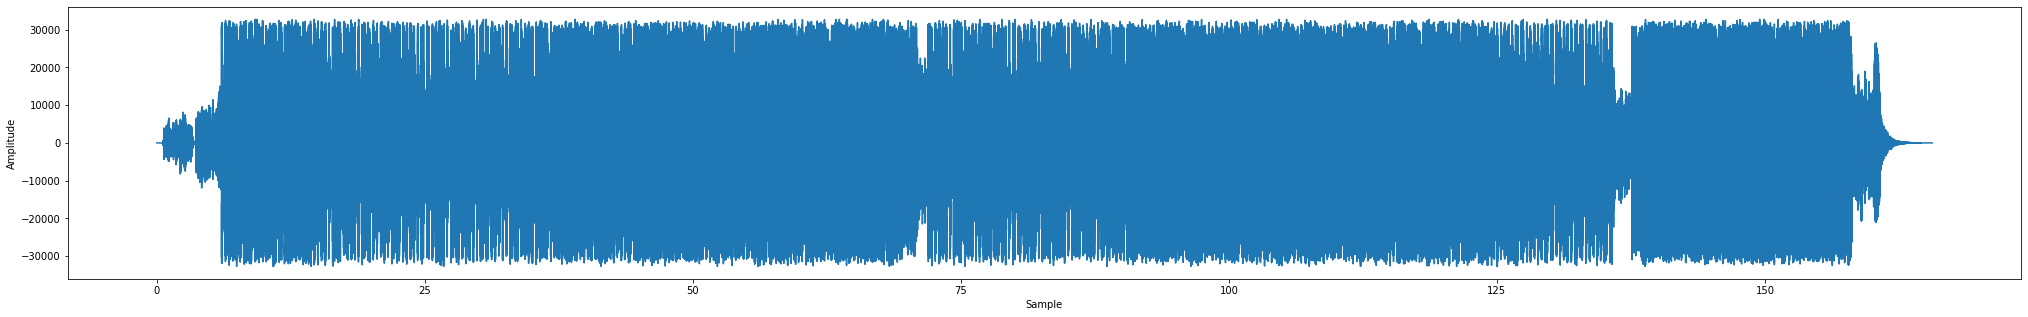

In [24]:
#tracé du signal 
fig = plt.figure(figsize=(35,5))
plt.plot(t,signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

**Variables Pour la NFFT**

In [272]:
NFFT = 4096 # FFT size
noverlap = int(NFFT/2) 

c:\Python37\lib\site-packages\matplotlib\axes\_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


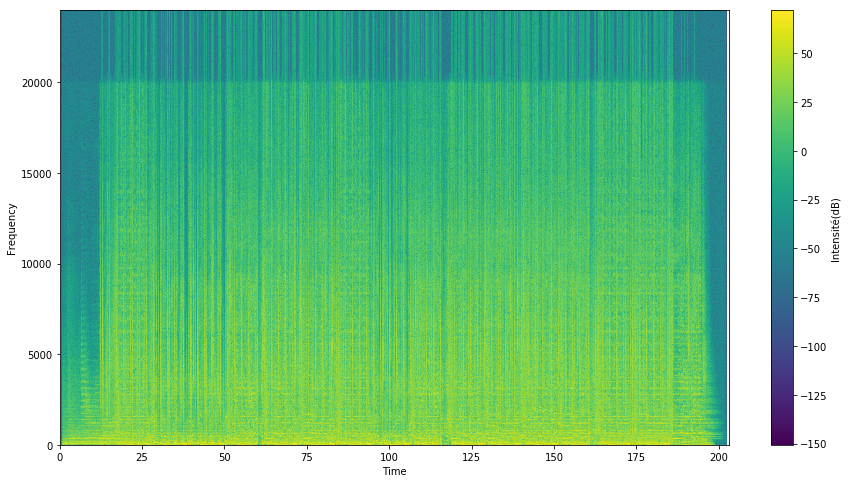

In [273]:
if choix_type == "mono":
    fig = plt.figure(figsize=(15,8))
    spectrum, freqs, t, im = plt.specgram(signal,NFFT=NFFT,Fs=s_rate,noverlap=noverlap)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    fig.colorbar(im).set_label('Intensité(dB)')

In [274]:
AMPLITUDE_PEAKS_MIN = 10    # minimum amplitude of peaks to be detected
NEIGHBORHOOD_SIZE = 20      # number of neighboring peaks to be considered

In [275]:
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
from scipy.ndimage.filters import maximum_filter

def get_2D_peaks(arr2D, plot=False, amp_min=AMPLITUDE_PEAKS_MIN, size_neighborhood=NEIGHBORHOOD_SIZE):
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, size_neighborhood)

    # find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max ^ eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    # scatter of the peaks
    if plot:
      fig, ax = plt.subplots(figsize=(25, 10))
      ax.imshow(arr2D)
      ax.scatter(time_idx, frequency_idx)
      ax.set_xlabel('Time')
      ax.set_ylabel('Frequency')
      ax.set_title("Spectrogram")
      plt.gca().invert_yaxis()
      plt.show()

    return list(zip(frequency_idx, time_idx))

In [276]:
#y_Peaks,x_Peaks = get_2D_peaks(spectrum, plot=False)
#len(y_Peaks)

In [277]:
#plt.plot(x_Peaks,y_Peaks,'r.')

In [278]:
# if choix_type == "mono":
#     fig = plt.figure(figsize=(15,8))
#     spectrum, freqs, t, im = plt.specgram(signal,NFFT=NFFT,Fs=s_rate,noverlap=noverlap)
#     plt.xlabel('Time')
#     plt.ylabel('Frequency')
#     fig.colorbar(im).set_label('Intensité(dB)')
#     plt.plot(t[x_Peaks],freqs[y_Peaks],'r.')

**Traitement avec mlab.specgram**

In [279]:
arr2D = mlab.specgram(
        signal,
        NFFT=4096,
        Fs=s_rate,
        window=mlab.window_hanning,
        noverlap=int(4096 * 0.5))[0]

In [280]:
#plt.plot(arr2D)

In [281]:
# apply log transform since specgram() returns linear array
arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D
arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

C:\Users\Anchl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


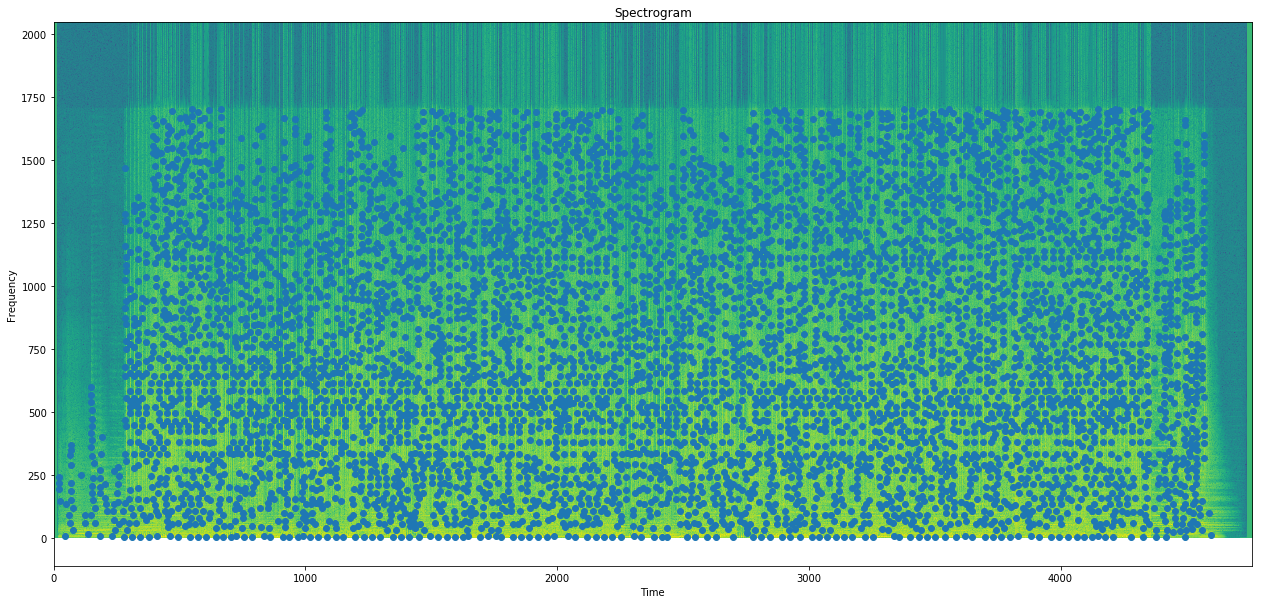

In [282]:
# find local maxima
local_maxima = get_2D_peaks(arr2D, plot=True)

**Calcul du Hash**

In [283]:
FINGERPRINT_PARING_DEGREE = 15
FINGERPRINT_REDUCTION = 20  # Pour optimiser la taille du hash
# pour savoir si une fingerprint est proche d'une autre
min_hash = 0
max_hash = 200

In [284]:
# from operator import itemgetter
# import hashlib

# def generate_hashes(peaks, fan_value=FINGERPRINT_PARING_DEGREE):
#     hashes = []
#     peaks.sort(key=itemgetter(1))

#     # bruteforce all peaks
#     for i in range(len(peaks)):
#       for j in range(1, fan_value):
#         if (i + j) < len(peaks):

#           # take current & next peak frequency value
#           freq1 = peaks[i][1]
#           freq2 = peaks[i + j][1]

#           # take current & next -peak time offset
#           t1 = peaks[i][0]
#           t2 = peaks[i + j][0]

#           # get diff of time offsets
#           t_delta = t2 - t1

#           # check if delta is between min & max
#           if t_delta >= min_hash and t_delta <= max_hash:
#             h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta)))
#             yield hashes.append((h.hexdigest()[0:FINGERPRINT_REDUCTION], t1))

In [285]:
from operator import itemgetter
import hashlib
from typing import List, Tuple

def generate_hashes(peaks: List[Tuple[int, int]], fan_value: int = FINGERPRINT_PARING_DEGREE) -> List[Tuple[str, int]]:
    """
    Hash list structure:
       sha1_hash[0:FINGERPRINT_REDUCTION]    time_offset
        [(e05b341a9b77a51fd26, 32), ... ]
    :param peaks: list of peak frequencies and times.
    :param fan_value: degree to which a fingerprint can be paired with its neighbors.
    :return: a list of hashes with their corresponding offsets.
    """
    # frequencies are in the first position of the tuples
    idx_freq = 0
    # times are in the second position of the tuples
    idx_time = 1

    peaks.sort(key=itemgetter(1))

    hashes = []
    for i in range(len(peaks)):
        for j in range(1, fan_value):
            if (i + j) < len(peaks):

                freq1 = peaks[i][idx_freq]
                freq2 = peaks[i + j][idx_freq]
                t1 = peaks[i][idx_time]
                t2 = peaks[i + j][idx_time]
                t_delta = t2 - t1

                if min_hash <= t_delta <= max_hash:
                    h = hashlib.sha1(f"{str(freq1)}|{str(freq2)}|{str(t_delta)}".encode('utf-8'))

                    hashes.append((h.hexdigest()[0:FINGERPRINT_REDUCTION], t1))

    return hashes

In [286]:
hash = generate_hashes(local_maxima)

In [287]:
len(hash)

86975

In [288]:
hash

[('dd1cf6f7ac0741314878', 23),
 ('d3ab21381e5e22c00445', 23),
 ('5bc3c685eda97be9a060', 23),
 ('0ae50a2cf28a1e1af9fa', 23),
 ('cc9c110f589befc2fb5f', 23),
 ('b41d33bee019ad63aca6', 23),
 ('f9f8728447a42df3dfa8', 23),
 ('0600d25e450c8745564c', 23),
 ('9541fded3b6d2984a01b', 23),
 ('bbcb4dc76a9795d3e19e', 23),
 ('3e89fd030228fc337f90', 23),
 ('65dc33d05d5578869db0', 23),
 ('69701c1e2621786a951f', 23),
 ('71694080d470442dde97', 23),
 ('25e0d8ac1546b1338866', 23),
 ('9bf1c9d41519cd3f5d17', 23),
 ('477bf22dc4a2891f9221', 23),
 ('fc6749082e55ae5659c3', 23),
 ('8b3706a4afa02eb035d3', 23),
 ('3c75f1f967cc2f4d5760', 23),
 ('c9c5a91135d6efe80b71', 23),
 ('9440a5981629859f9294', 23),
 ('07dcf94787c7822d6419', 23),
 ('fa591a4c2ef066127a7c', 23),
 ('cf76470186d8fe489fbf', 23),
 ('124fe7c517ab7cf77970', 23),
 ('7d37baa9d1ba0d678f81', 23),
 ('d0c39c0b732f4d116cad', 23),
 ('e839a52e5362a5bc7b75', 23),
 ('2452d18054272168a367', 23),
 ('3cfac15e873aeae4a599', 23),
 ('5edbd9a5bff7ec992cb6', 23),
 ('b57f0